<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1f_regresion_logistica_tarea_moral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión Softmax: tarea

En este ejercicio debes extender el modelo de regresión logística para Iris para realizar clasificación multiclase sobre todos los atributos del conjunto.


* Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.
* Programa la exactitud multiclase y evalúa el modelo con esta métrica.
* Prueba distintos valores para los hiperparámetros.
* Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros que probaste.

# Bibiotecas

In [1]:
# sistema de archivos
import os
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url


# directorio de datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/iris/iris.csv'
base_dir = '../data/iris/'
filename = 'iris.csv'
filepath = os.path.join(base_dir, 'iris.csv')


# para reproducibilidad
SEED = 1
torch.manual_seed(SEED)

# Se cargan y preparan los datos

In [2]:
#se obtienen los datos
columns = ('largo sépalo', 'ancho sépalo', 'largo pétalo', 'ancho pétalo', 'clase')
df = pd.read_csv('../data/iris/iris.csv', names=columns)
pd.concat((df[1:5], df[50:55], df[100:105]))  

,largo sépalo,ancho sépalo,largo pétalo,ancho pétalo,clase
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica


In [3]:
label2index = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
x_trn = np.array(df.iloc[:, 0:4][:150], dtype="float32")
y_trn = [label2index[l] for l in df.iloc[:, -1][:150]]
y_trn = np.array(y_trn, dtype="float32")[..., np.newaxis]
print('Los datos de entrenamiento son {} ejemplos, con {} atributos cada uno \n El número total de etiquetas es: {}, con dimension del vector: {}'.format(len(x_trn),x_trn.shape[1], len(y_trn), y_trn.shape))

Los datos de entrenamiento son 150 ejemplos, con 4 atributos cada uno 
 El número total de etiquetas es: 150, con dimension del vector: (150, 1)


## Realizamos algunas visualizaciones de los datos tomando  los atributos po partes

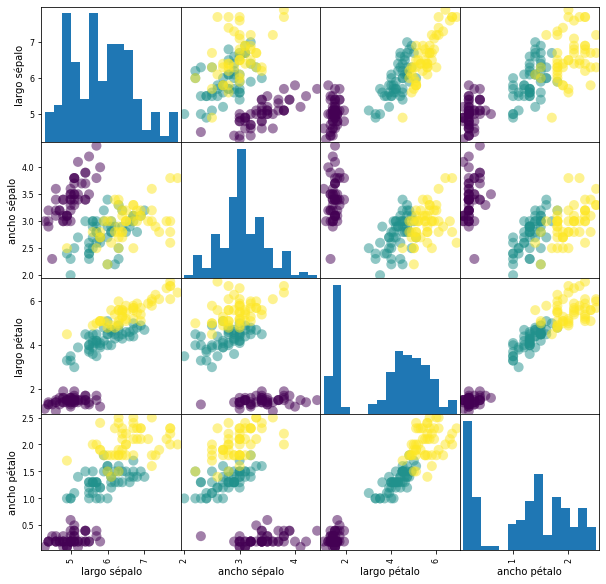

In [18]:
from matplotlib import cm
df = pd.DataFrame(x_trn, columns=['largo sépalo', 'ancho sépalo', 'largo pétalo', 'ancho pétalo'])
scatter = pd.plotting.scatter_matrix(df, c= y_trn, marker = 'o', s=100, hist_kwds={'bins':15}, figsize=(10,10), cmap='viridis')

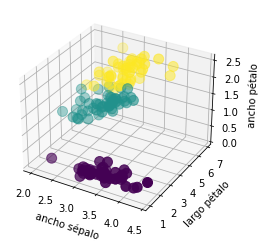

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_trn[:,1], x_trn[:,2], x_trn[:,3], c = y_trn, marker = 'o', s=100)
ax.set_xlabel('ancho sépalo')
ax.set_ylabel('largo pétalo')
ax.set_zlabel('ancho pétalo')
plt.show()

## Se crea el DataSet y el DataLoader

In [6]:
class IrisDS:
    
    def __init__(self, X, Y):
        self.x = X
        self.y = Y

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.y)

In [7]:
# tamaño del lote
batch_size = 16

# creamos un Dataset
ds = IrisDS(x_trn, y_trn)

# creamos un DataLoader
trn_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 4]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


In [8]:
len(ds)

150

## Se crea el modelo a alto y a medio nivel

In [9]:
#Modelo a alto nivel
model = nn.Sequential(
    nn.Linear(4, 3),
#     nn.Softmax(dim=1)
)

In [10]:
# # Modelo a medio nivel 
# #se define la clase RegLog que hereda de torch.nn.Module
# class RegLog(nn.Module):

#     #se define el inicializador
#     def __init__(self):
#         # se llama al inicializador de la clase padre
#         super(RegLog, self).__init__()
#         # importante: se definen las capas como atributos de la clase
#         self.fc = nn.Linear(4, 3)

#     # método para inferencia
#     def forward(self, x):
#         # definición de arquitectura 
#         x = self.fc(x)
#         x = torch.softmax(x)
#         return x

# model = RegLog()

In [11]:
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
)


## Entrenamiento

In [28]:
# optimizador
opt = optim.SGD(model.parameters(), lr=0.05)

# historial de pérdida
losses, accs = [], []

# ciclo de entrenamiento
EPOCHS = 200
for epoch in range(EPOCHS):

    
    # historial de pérdida
    losses_epoch, accs_epoch = [], []
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia
        y_lgts = model(x)
#         print(y_prob, np.squeeze(y_true).long())
#         y_prob = F.softmax(y_lgts, 1)
#         print(y_lgts.dtype,'\t', y_true.dtype)
        # calculamos de pérdida
#         loss = F.cross_entropy(y_prob, np.squeeze(y_true).long())
        loss = F.cross_entropy(y_lgts, torch.squeeze(y_true).long())
        #obtenemos la distribución de probabilidad
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
#         y_pred = torch.argmax(y_prob)
        # calculamos la exactitud
        acc = (y_true == y_pred[...,np.newaxis]).type(torch.float32).mean()
#         print(y_true, y_pred)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        losses_epoch.append(loss.item() * 100)
        accs_epoch.append(acc.item() * 100)

    # imprimimos métricas
    loss = np.mean(losses_epoch)
    acc = np.mean(accs_epoch)
    print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
    losses.append(loss)
    accs.append(acc)

E 0 loss=  7.45 acc=97.50
E 1 loss=  6.62 acc=97.50
E 2 loss=  6.95 acc=97.50
E 3 loss=  6.83 acc=97.50
E 4 loss=  7.05 acc=98.12
E 5 loss=  7.18 acc=97.50
E 6 loss=  6.61 acc=97.50
E 7 loss=  7.27 acc=96.88
E 8 loss=  6.97 acc=96.88
E 9 loss=  6.88 acc=98.12
E10 loss=  6.85 acc=97.50
E11 loss=  6.65 acc=97.50
E12 loss=  7.42 acc=97.50
E13 loss=  6.85 acc=98.12
E14 loss=  6.80 acc=98.12
E15 loss=  7.21 acc=97.50
E16 loss=  6.63 acc=98.12
E17 loss=  7.06 acc=96.88
E18 loss=  6.65 acc=98.12
E19 loss=  6.97 acc=98.75
E20 loss=  7.22 acc=97.50
E21 loss=  7.27 acc=97.50
E22 loss=  8.84 acc=96.46
E23 loss=  7.33 acc=97.50
E24 loss=  6.51 acc=98.12
E25 loss=  7.15 acc=97.50
E26 loss=  6.43 acc=98.12
E27 loss=  6.55 acc=98.12
E28 loss=  6.78 acc=97.50
E29 loss=  7.06 acc=97.50
E30 loss=  6.56 acc=98.12
E31 loss=  7.31 acc=98.12
E32 loss=  6.76 acc=98.12
E33 loss=  6.80 acc=97.50
E34 loss=  6.59 acc=98.12
E35 loss=  6.71 acc=98.12
E36 loss=  6.89 acc=97.50
E37 loss=  6.51 acc=97.50
E38 loss=  6

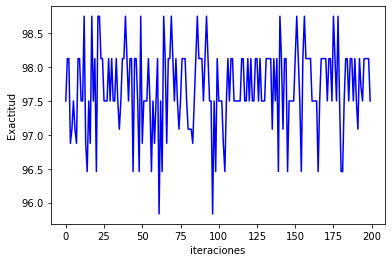

In [26]:
%matplotlib inline
plt.plot(accs, color='blue')
plt.xlabel('iteraciones')
plt.ylabel('Exactitud');

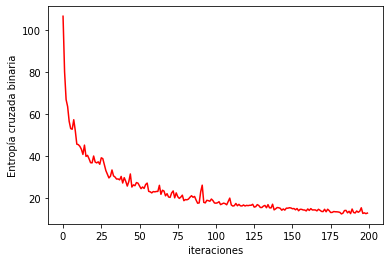

In [14]:
plt.plot(losses, color='red')
plt.xlabel('iteraciones')
plt.ylabel('Entropía cruzada binaria');

In [15]:
[w, b] = model.parameters()

In [16]:
w

Parameter containing:
tensor([[ 0.9568,  1.6839, -2.7647, -1.6924],
        [ 0.7420, -0.3491, -0.2620, -0.9256],
        [-1.6955, -2.0583,  2.9881,  2.6617]], requires_grad=True)

In [17]:
b

Parameter containing:
tensor([ 0.6427,  0.4998, -0.9690], requires_grad=True)